In [350]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.optim import lr_scheduler as schecduler

import torchvision
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

from helperFunctions import accuracy_fn

In [351]:
training_set = CIFAR10(root="data", 
                        train=True, 
                        download=True, 
                        transform=torchvision.transforms.ToTensor(), 
                        target_transform=None)

training_size = int(0.9 * len(training_set))

training_set, validation_set = random_split(training_set, [training_size, len(training_set) - training_size])

testing_set = CIFAR10(
    root="data",
    train=False,
    download=True,    
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)


Files already downloaded and verified
Files already downloaded and verified


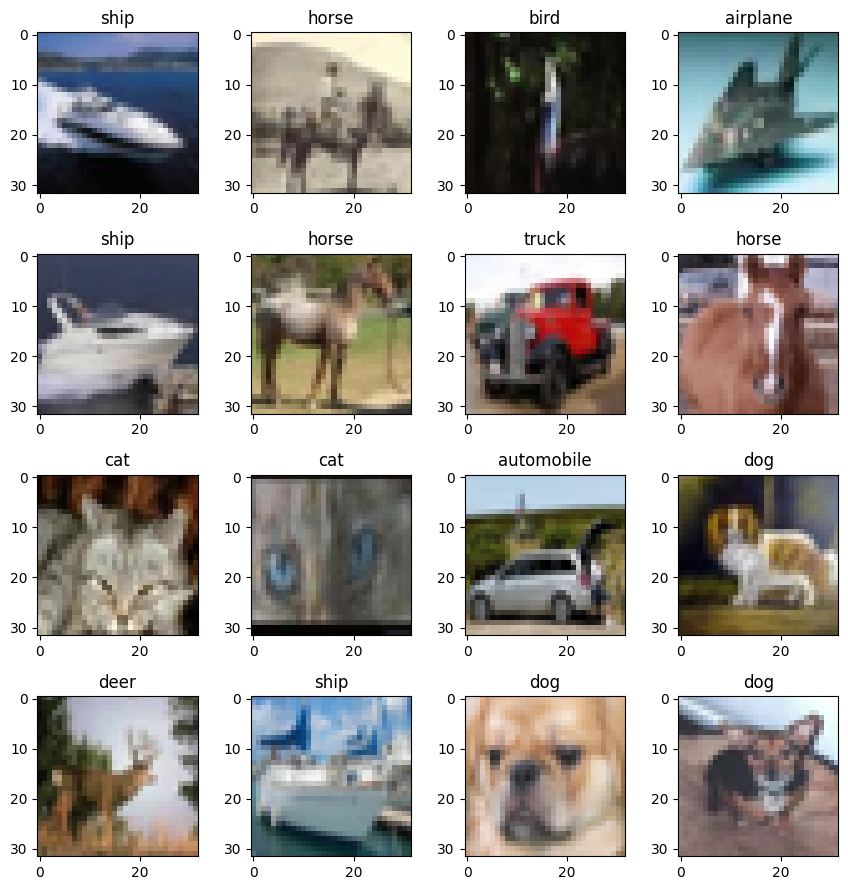

In [352]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(training_set), size=[1]).item()
    img, label = training_set[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(training_set.dataset.classes[label])
    plt.tight_layout()

In [353]:
training_set.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [354]:
class CIFARClassifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.BLOCK_2_HIDDEN_UNITS = hidden_units * 2
        self.BLOCK_3_HIDDEN_UNITS = self.BLOCK_2_HIDDEN_UNITS * 2

        self.CONVBLOCK1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=self.BLOCK_2_HIDDEN_UNITS, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.BLOCK_2_HIDDEN_UNITS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.CONVBLOCK2 = nn.Sequential(
            nn.Conv2d(in_channels=self.BLOCK_2_HIDDEN_UNITS, out_channels=self.BLOCK_2_HIDDEN_UNITS, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.BLOCK_2_HIDDEN_UNITS),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.BLOCK_2_HIDDEN_UNITS, out_channels=self.BLOCK_3_HIDDEN_UNITS, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.BLOCK_3_HIDDEN_UNITS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.CONVBLOCK3 = nn.Sequential(
            nn.Conv2d(in_channels=self.BLOCK_3_HIDDEN_UNITS, out_channels=self.BLOCK_3_HIDDEN_UNITS, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.BLOCK_3_HIDDEN_UNITS),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.BLOCK_3_HIDDEN_UNITS, out_channels=self.BLOCK_3_HIDDEN_UNITS, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.BLOCK_3_HIDDEN_UNITS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        self.CLASSIFIER = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features=self.BLOCK_3_HIDDEN_UNITS * 7 * 7, out_features=output_shape)
        )

    def forward(self, X: torch.Tensor):
        X = self.CONVBLOCK1(X)
        X = self.CONVBLOCK2(X)
        X = self.CONVBLOCK3(X)
        X = self.CLASSIFIER(X)
        return X

In [355]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=training_set, shuffle=True, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(dataset=validation_set, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=testing_set, batch_size=BATCH_SIZE)

In [356]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [357]:
device = "cuda" if torch.cuda.is_available else "cpu"

def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                lossfx: torch.nn.Module,
                optim: torch.optim.Optimizer,
                accuracyfx,
                device: torch.device = device):
            
    train_loss, train_acc = 0, 0

    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)  
        
        loss = lossfx(y_pred, y)
        
        train_loss += loss
        train_acc += accuracyfx(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        optim.zero_grad()
        
        loss.backward()  
        
        optim.step()
    
    print(f"Epoch {epoch}: Loss {train_loss/len(dataloader):.5f} Accuracy {train_acc/len(dataloader):.2f}")


def val_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                lossfx: torch.nn.Module,
                accuracyfx,
                device: torch.device = device):

    test_loss, test_acc = 0, 0
    
    model.to(device)
    model.eval() 
    
    with torch.inference_mode(): 
        
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += lossfx(test_pred, y)
            test_acc += accuracyfx(y_true=y,
                y_pred=test_pred.argmax(dim=1) 
            )
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def test_model(model: torch.nn.Module, 
                data_loader: torch.utils.data.DataLoader, 
                accuracy_fn, device: torch.device = device):
    model.to(device)
    model.eval() 
    test_acc = 0

    with torch.no_grad():


        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    avg_test_acc = test_acc / len(data_loader)
    print(f"Test Accuracy: {avg_test_acc:.2f}%")

In [358]:
cifar_model = CIFARClassifier(input_shape=3, hidden_units=40, output_shape=len(testing_set.classes))

UNTRAINEDSTATE = cifar_model.state_dict()

In [359]:
test_model(model=cifar_model, data_loader=test_dataloader, accuracy_fn=accuracy_fn, device=device)

Test Accuracy: 10.01%


In [360]:
cifar_model.load_state_dict(UNTRAINEDSTATE)

loss_fx = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cifar_model.parameters(), lr=0.1)
scheduler = schecduler.MultiStepLR(optimizer, milestones=[15, 35, 45], gamma=0.1)
epochs = 50

for epoch in range(epochs):
    print (f"Epoch {epoch}---------------------------------------------------------------->")

    train_step(model=cifar_model, dataloader=train_dataloader, lossfx=loss_fx, optim=optimizer, accuracyfx=accuracy_fn, device=device)

    val_step(model=cifar_model, data_loader=validation_dataloader, lossfx=loss_fx, accuracyfx=accuracy_fn, device=device)

Epoch 0---------------------------------------------------------------->
Epoch 0: Loss 1.83883 Accuracy 37.98
Test loss: 2.63747 | Test accuracy: 29.60%

Epoch 1---------------------------------------------------------------->
Epoch 1: Loss 1.15000 Accuracy 58.85
Test loss: 1.36938 | Test accuracy: 51.07%

Epoch 2---------------------------------------------------------------->
Epoch 2: Loss 0.88530 Accuracy 68.62
Test loss: 1.11646 | Test accuracy: 61.56%

Epoch 3---------------------------------------------------------------->
Epoch 3: Loss 0.73254 Accuracy 74.32
Test loss: 1.34174 | Test accuracy: 57.76%

Epoch 4---------------------------------------------------------------->
Epoch 4: Loss 0.62376 Accuracy 78.30
Test loss: 0.74870 | Test accuracy: 73.85%

Epoch 5---------------------------------------------------------------->
Epoch 5: Loss 0.54160 Accuracy 81.10
Test loss: 0.63179 | Test accuracy: 78.42%

Epoch 6---------------------------------------------------------------->
Epo

In [363]:
test_model(model=cifar_model, data_loader=test_dataloader, accuracy_fn=accuracy_fn, device=device)

Test Accuracy: 84.93%


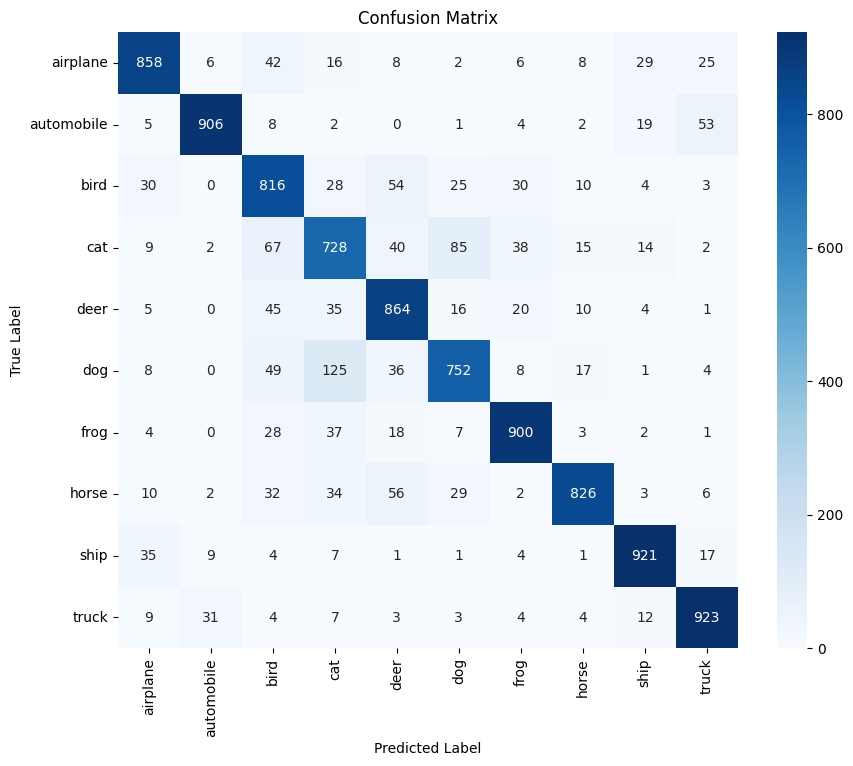

In [365]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def generate_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            all_preds.append(preds.argmax(dim=1).cpu().numpy())
            all_labels.append(y.cpu().numpy())
    
    return np.concatenate(all_labels), np.concatenate(all_preds)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get predictions
y_true, y_pred = generate_predictions(cifar_model, test_dataloader, device)

# Get class names
classes = testing_set.classes  # Ensure you have this variable

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)
